# Efficient Gaussian Random Field Inference on Graphs - Regression Task on Traffic Dataset

This notebook contains the following:

1. Showing the baseline performance using the exact diffusion kernel.
2. Showing the similar level performance using Product of Feature Matrices (PoFM) kernel, compared across the parameter 'max_expansion' which determines the order of the approximation.
3. Showing the convergence of the GRF to the PoFM kernel for 'max_expansion = 5'
4. (Opt) Showing the performance of grf kernel with arbitrary modulation function. 

## Setup

In [1]:
import tensorflow as tf
import numpy as np
import scipy.special
import gpflow
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
import networkx as nx
from gpflow.utilities import print_summary
import tensorflow_probability as tfp
import seaborn as sns
from tqdm import tqdm

import sys
import os
project_root = os.path.abspath("../..")
sys.path.append(project_root)

from efficient_graph_gp.graph_kernels import get_normalized_laplacian
from efficient_graph_gp.gpflow_kernels import GraphDiffusionFastGRFKernel, GraphDiffusionPoFMKernel, GraphDiffusionKernel, GraphGeneralPoFMKernel, GraphGeneralFastGRFKernel
from utils import compute_fro
from traffic_utils.preprocessing import load_PEMS
from traffic_utils.plotting import plot_PEMS

2025-09-17 11:26:25.654552: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-17 11:26:25.667456: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758104785.681995 4082561 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758104785.686986 4082561 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1758104785.697973 4082561 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
# Load and preprocess the PEMS dataset

np.random.seed(1111)
num_eigenpairs = 500
dataset = 'PeMS-Bay-new'
num_train = 250

G, data_train, data_test, data = load_PEMS(num_train=num_train)
x_train, y_train = data_train
x_test, y_test = data_test
x, y = data
orig_mean, orig_std = np.mean(y_train), np.std(y_train)
y_train = (y_train-orig_mean)/orig_std
y_test = (y_test-orig_mean)/orig_std

X_train = tf.convert_to_tensor(x_train)
X_full = tf.convert_to_tensor(x)
Y_train = tf.convert_to_tensor(y_train)

adjacency_matrix = nx.to_numpy_array(G)  # Converts to NumPy adjacency matrix
print(adjacency_matrix.shape)  # Check matrix size

/scratches/cartwright/mz473/Efficient-Gaussian-Process-on-Graphs/experiments_dense/traffic_dataset/traffic_utils/preprocessing.py:90: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again as this compatibility may be removed in a future version of shapely.
  G = pickle.load(f)


epsg:4326
(1016, 1016)


I0000 00:00:1758104844.915234 4082561 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9617 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:17:00.0, compute capability: 7.5
I0000 00:00:1758104844.916600 4082561 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9608 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:b3:00.0, compute capability: 7.5


In [12]:
def gp_training(X,Y,X_new, graph_kernel):
    model = gpflow.models.GPR(data=(X, Y), kernel=graph_kernel, mean_function=None,noise_variance=0.01)
    
    # # Explicitly set dtype to float32
    # dtype = tf.float64
    # # Assign Uniform prior with explicitly cast float32 values
    # model.kernel.beta.prior = tfp.distributions.Uniform(
    #     low=tf.constant(0.0, dtype=dtype), 
    #     high=tf.constant(2.0, dtype=dtype)
    # )
    
    gpflow.optimizers.Scipy().minimize(model.training_loss, model.trainable_variables)
    mean, variance = model.predict_f(X_new)
    stddev = tf.sqrt(variance)
    return model, mean, stddev

def configure_model(model, hyperparameters):
    model.kernel.beta.assign(hyperparameters['beta'])
    model.kernel.sigma_f.assign(hyperparameters['sigma_f'])
    model.likelihood.variance.assign(hyperparameters['variance'])
    return model

def configure_model_general(model, hyperparameters):
    model.kernel.modulator_vector.assign(hyperparameters['modulator_vector'])
    model.likelihood.variance.assign(hyperparameters['variance'])
    return model

def gp_inference(model, X_new):
    mean, variance = model.predict_f(X_new)
    stddev = tf.sqrt(variance)
    return mean, stddev

def evaluate(model, x_test, y_test, quiet=False):
    
    lml = model.log_marginal_likelihood().numpy()
    
    mean, cov = model.predict_f(x_test, full_cov=True)
    rmse = orig_std * np.sqrt(np.mean((y_test.ravel() - mean.numpy().ravel())**2))
    
    mean, cov = tf.reshape(mean, [-1]), cov[0]
    cov = cov + tf.linalg.diag(tf.fill([len(y_test)], model.likelihood.variance))
    dist = tfp.distributions.MultivariateNormalTriL(mean, cov)
    nlpd = -dist.log_prob(tf.reshape(y_test, [-1])).numpy()
    
    if not quiet:
        print(f"Log Marginal Likelihood: {lml}")
        print(f"RMSE: {rmse}")
        print(f"NLPD: {nlpd}")
    
    return lml, rmse, nlpd

## 0. Learn a good set of hyper-parameters with the PoFM Kernel

We use the PoFM kernel to learn a set of hyper-param with physical sense. 

In short, the results confirm a very sparse, low-clustering, weakly connected graph with long weighted distances and slowly growing multi-hop neighborhoods. Any neighborhood-based GNN or Laplacian-based model will need to account for these structural properties—likely by choosing enough hops to capture relevant context without excessive computational overhead.

We use a neighbourhood size of 5-hop to avoid **oversmoothing**.

/tmp/ipykernel_4082561/3633228529.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


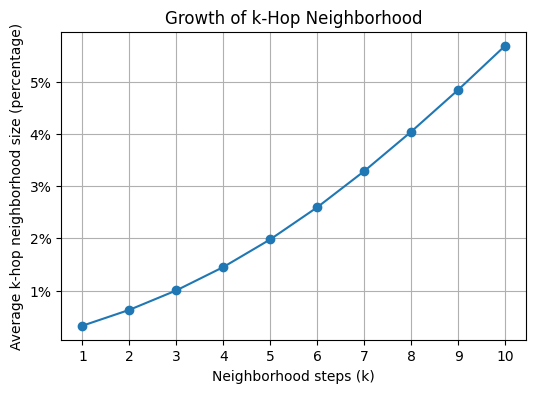

In [4]:
# ------------------------------------------
# 2. Create a NetworkX Graph from the Matrix
# ------------------------------------------
# This builds an undirected weighted graph.
G = nx.from_numpy_array(adjacency_matrix)

# -----------------------------------------------------------
# 7. Explore k-Step Neighborhood Aggregation (Ego Networks)
# -----------------------------------------------------------
# This helps understand how many nodes are reached as we aggregate neighbors.
def neighborhood_size(G, node, k):
    """
    Returns the set of nodes within k steps from the given node.
    """
    # nx.ego_graph returns the subgraph induced by nodes within radius=k.
    return nx.ego_graph(G, node, radius=k).nodes()

max_k = 10  # Feel free to extend this range based on your needs.
avg_neighborhood = {}
graph_size = len(G.nodes())


for k in range(1, max_k + 1):
    sizes = []
    for node in G.nodes():
        sizes.append(len(list(neighborhood_size(G, node, k))))
    avg_neighborhood[k] = np.mean(sizes) / graph_size

# Plot the growth of the k-hop neighborhood.
plt.figure(figsize=(6, 4))
plt.plot(list(avg_neighborhood.keys()), list(avg_neighborhood.values()), marker='o')
plt.xlabel("Neighborhood steps (k)")
plt.ylabel("Average k-hop neighborhood size (percentage)")
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.title("Growth of k-Hop Neighborhood")
plt.xticks(range(1, max_k+1))
plt.grid(True)
plt.show()


In [5]:
MAX_WALK_LENGTH = 3

## 1.1 Performance of PoFM Kernel

In [17]:
# The normalized laplacian is used
graph_kernel = GraphDiffusionPoFMKernel(adjacency_matrix,
                                        max_expansion=MAX_WALK_LENGTH,
                                        normalize_laplacian=True)

model, mean, stddev = gp_training(X_train, Y_train, X_full, graph_kernel)
print_summary(model)

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │    value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════╡
│ GPR.kernel.beta         │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 2.18522  │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ GPR.kernel.sigma_f      │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 1.45713  │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 0.203835 │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧══════

In [18]:
pofm_lml, pofm_rmse, pofm_nlpd = evaluate(model, x_test, y_test)

Log Marginal Likelihood: -342.5482822527671
RMSE: 13.990883235081197
NLPD: 101.77886913400596


In [ ]:
learned_hyperparameters = {
    "beta": model.kernel.beta.numpy(),
    "sigma_f": model.kernel.sigma_f.numpy(),
    "variance": model.likelihood.variance.numpy()
}

## 1.2 Performance of the Exact Diffusion Kernel

In [20]:
graph_kernel = GraphDiffusionKernel(adjacency_matrix, normalize_laplacian=True)
model = gpflow.models.GPR(data=(X_train, Y_train), kernel=graph_kernel, mean_function=None, noise_variance=0.01)
model = configure_model(model, learned_hyperparameters)
mean, stddev = gp_inference(model, X_full)

In [21]:
diffusion_lml, diffusion_rmse, diffusion_nlpd = evaluate(model, x_test, y_test)

Log Marginal Likelihood: -349.08321650501927
RMSE: 14.395480131728526
NLPD: 100.68403323896857


## 1.2* Oversmoothed Diffusion Kernel (Quoted in Paper)

In [22]:
graph_kernel = GraphDiffusionKernel(adjacency_matrix, normalize_laplacian=True)
model, mean, stddev = gp_training(X_train, Y_train, X_full, graph_kernel)
print_summary(model)

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │      value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════╡
│ GPR.kernel.beta         │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 109.792    │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ GPR.kernel.sigma_f      │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │   3.62689  │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │   0.453167 │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧════

In [23]:
o_diffusion_lml, o_diffusion_rmse, o_diffusion_nlpd = evaluate(model, x_test, y_test)

Log Marginal Likelihood: -315.4917327664773
RMSE: 12.581960980113235
NLPD: 95.87564466006117


## 2 Learn the Hyperparameters Directly with GRF

### 2.2 Track the RMSE / NLPD for Prediction 


We expect this to reach similar level of performance as the truncated diffusion kernel (PoFM)

The fact that we can learn the hyperparam (beta) means that this should looks better than simply comparing the frobenious norm between the PoFM gram matrix and the GRF gram matrix - although they would converge eventually.

In the later code, we learned these two GRF kernels:

1. A GRF kernel that use a diffusion kernel to parameterise the modulation function (hence a Diffusion-shape GRF kernel)
2. A GRF kernel with arbitray modulation function

In [24]:
# This is when we use GRF to learn a Diffusion-shaped Kernel

walks_per_nodes = [1,2,4,8,16,32,64,128,256,512,1024,2048,4096,8192]
grf_metrics = []


for walks_per_node in tqdm(walks_per_nodes, desc='Walk lengths'):
    # Create the graph kernel with the current walk length
    graph_kernel = GraphDiffusionFastGRFKernel(adjacency_matrix,
                                               walks_per_node=walks_per_node,
                                               p_halt=0.1,
                                               max_walk_length=MAX_WALK_LENGTH+1,
                                               beta = learned_hyperparameters['beta'],
                                               normalize_laplacian=True)
    
    # model = gpflow.models.GPR(data=(X_train, Y_train), kernel=graph_kernel, mean_function=None,noise_variance=0.01)
    # model = configure_model(model, learned_hyperparameters)
    # mean, stddev = gp_inference(model, X_full)
    model, mean, stddev = gp_training(X_train, Y_train, X_full, graph_kernel)
    lml, rmse, nlpd = evaluate(model, x_test, y_test, quiet=True)
    results = {'walks_per_node': walks_per_node,
                'lml': lml,
                'rmse': rmse,
                'nlpd': nlpd}
    grf_metrics.append(results)


Walk lengths:   0%|          | 0/14 [00:00<?, ?it/s]

Walk lengths: 100%|██████████| 14/14 [02:04<00:00,  8.92s/it]


In [26]:
walks_per_nodes = [1,2,4,8,16,32,64,128,256,512,1024,2048,4096,8192]
a_grf_metrics = []


for walks_per_node in tqdm(walks_per_nodes, desc='Walk lengths'):
    # Create the graph kernel with the current walk length
    graph_kernel = GraphGeneralFastGRFKernel(adjacency_matrix,
                                             walks_per_node=walks_per_node,
                                             p_halt=0.1,
                                             max_walk_length=MAX_WALK_LENGTH,
                                             modulator_vector=None) # Randomly initialize the modulator vector
    
    model, mean, stddev = gp_training(X_train, Y_train, X_full, graph_kernel)
    lml, rmse, nlpd = evaluate(model, x_test, y_test, quiet=True)
    results = {'walks_per_node': walks_per_node,
                'lml': lml,
                'rmse': rmse,
                'nlpd': nlpd}
    a_grf_metrics.append(results)


Walk lengths: 100%|██████████| 14/14 [01:46<00:00,  7.59s/it]


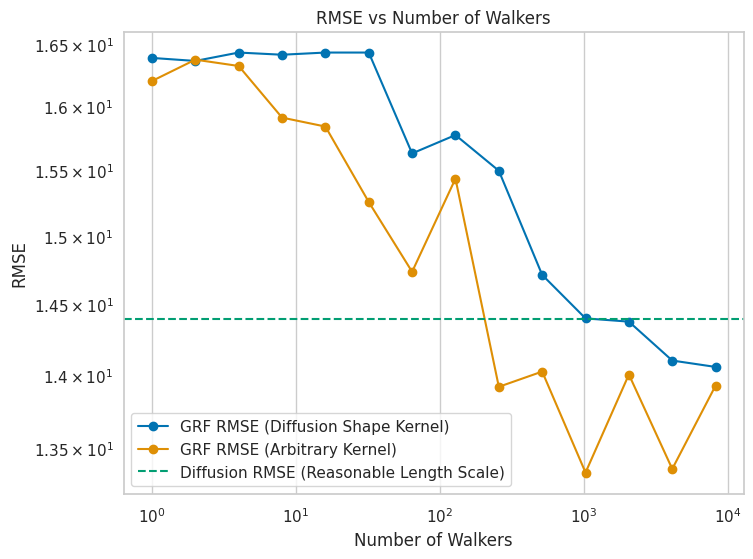

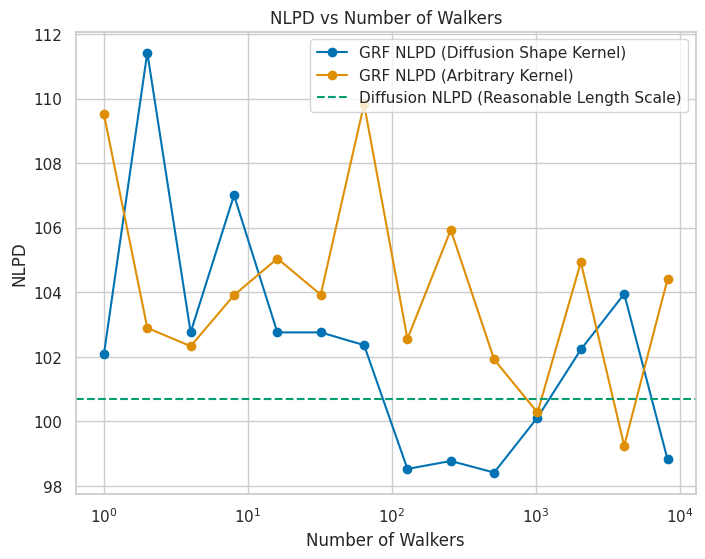

In [29]:
sns.set(style="whitegrid")

# Define color palette
palette = sns.color_palette("colorblind", n_colors=4)
color_diffusion = palette[0]  # Shared color for GRF Diff & PoFM Diff
color_arbitrary = palette[1]  # Shared color for GRF Arb & PoFM Arb
color_reasonable = palette[2]  # Diffusion reasonable length scale
color_large = palette[3]  # Diffusion very large length scale

# Extract RMSE and NLPD values from metrics
walks_grf = [metric['walks_per_node'] for metric in grf_metrics]
rmse_grf = [metric['rmse'] for metric in grf_metrics]
nlpd_grf = [metric['nlpd'] for metric in grf_metrics]

walks_a_grf = [metric['walks_per_node'] for metric in a_grf_metrics]
rmse_a_grf = [metric['rmse'] for metric in a_grf_metrics]
nlpd_a_grf = [metric['nlpd'] for metric in a_grf_metrics]

# Plot 1: RMSE
plt.figure(figsize=(8, 6))

# Plot GRF curves
plt.plot(walks_grf, rmse_grf, marker='o', linestyle='-', color=color_diffusion,
         label='GRF RMSE (Diffusion Shape Kernel)')
plt.plot(walks_a_grf, rmse_a_grf, marker='o', linestyle='-', color=color_arbitrary,
         label='GRF RMSE (Arbitrary Kernel)')

# Diffusion horizontal lines
plt.axhline(y=diffusion_rmse, color=color_reasonable, linestyle='--',
            label='Diffusion RMSE (Reasonable Length Scale)')

# Labels and formatting
plt.xlabel('Number of Walkers')
plt.xscale('log')
plt.ylabel('RMSE')
plt.yscale('log')
plt.title('RMSE vs Number of Walkers')

plt.legend()
plt.grid(True)
plt.show()

# Plot 2: NLPD
plt.figure(figsize=(8, 6))

# Plot GRF curves
plt.plot(walks_grf, nlpd_grf, marker='o', linestyle='-', color=color_diffusion,
         label='GRF NLPD (Diffusion Shape Kernel)')
plt.plot(walks_a_grf, nlpd_a_grf, marker='o', linestyle='-', color=color_arbitrary,
         label='GRF NLPD (Arbitrary Kernel)')

# Diffusion horizontal lines
plt.axhline(y=diffusion_nlpd, color=color_reasonable, linestyle='--',
            label='Diffusion NLPD (Reasonable Length Scale)')

# Labels and formatting
plt.xlabel('Number of Walkers')
plt.xscale('log')
plt.ylabel('NLPD')
plt.title('NLPD vs Number of Walkers')

plt.legend()
plt.grid(True)
plt.show()